In [52]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy import stats
from sklearn.decomposition import PCA
import argparse
from sklearn.preprocessing import MinMaxScaler

from tensorflow import keras
from keras.models import load_model
import pandas as pd
import shap
import numpy as np

import tensorflow as tf

print(f'tensorflow version {tf.__version__}')

from imblearn.over_sampling import SMOTE
from collections import Counter
from numpy import * 

import pandas as pd
import io
import requests
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Activation, Dropout


tensorflow version 2.10.0


In [60]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn import metrics

def plot_roc(pred,y):
    fpr, tpr, _ = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()
    
def test_models(model, x_test, y_test):
    
    pred = model.predict(x_test)

    plot_roc(pred,y_test)


    score = metrics.accuracy_score(y_test, np.round(pred))
    print(f"Accuracy score: {score}")


    cm = confusion_matrix(y_test, np.round(pred))
    np.set_printoptions(precision=2)
    print(cm)


In [53]:
def generate_dataset(n=3000, noise=1, c1=0.5, c2=0.5, p1=0.5, p2=0.5):
    x = np.zeros((n,2))
    
    x[:,0] = np.random.uniform(size=n)
    x[:,1] = p1*np.random.uniform(size=n) + p2*x[:,0]
    coeffs = np.array([c1,c2]).reshape(2,1)
    
    scaler = preprocessing.StandardScaler().fit(x)
    x = scaler.transform(x)
    
    delta = np.random.normal(0, noise, size=(n,1)) # standard deviation
    
    p = np.dot(x,coeffs).reshape(n,1) + delta.reshape(n,1)
    p = MinMaxScaler().fit_transform(p)
    
    y = np.zeros((n,1))
    for i in range(n): y[i] = np.random.binomial(1, p[i], size=1)
    
    return x,y,p

In [57]:
x,y,p = generate_dataset(n=3000, noise=1, c1=0.5, c2=0.5, p1=0.5, p2=0.5)
x_val,y_val,p_val = generate_dataset(n=1000, noise=1, c1=0.5, c2=0.5, p1=0.5, p2=0.5)
x_test,y_test,p_test = generate_dataset(n=1000, noise=1, c1=0.5, c2=0.5, p1=0.5, p2=0.5)

In [72]:
model_std_relu_dropout = Sequential()
model_std_relu_dropout.add(Dense(512, input_dim=2, activation='relu'))
model_std_relu_dropout.add(Dropout(0.5))
model_std_relu_dropout.add(Dense(1,activation='sigmoid')) # Output
model_std_relu_dropout.compile(loss='binary_crossentropy', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, 
        verbose=1, mode='auto', restore_best_weights=True)

model_std_relu_dropout.fit(x,y,validation_data=(x_val,y_val),
        callbacks=[monitor],epochs=10)


Epoch 1/10
 1/94 [..............................] - ETA: 31s - loss: 0.7099

2022-11-28 18:11:32.841938: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


94/94 [==============================] - 1s 8ms/step - loss: 0.6789 - val_loss: 0.6636
Epoch 2/10
 1/94 [..............................] - ETA: 0s - loss: 0.7501

2022-11-28 18:11:33.584430: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


94/94 [==============================] - 0s 5ms/step - loss: 0.6752 - val_loss: 0.6631
Epoch 3/10
94/94 [==============================] - 1s 6ms/step - loss: 0.6754 - val_loss: 0.6632
Epoch 4/10
94/94 [==============================] - 1s 5ms/step - loss: 0.6750 - val_loss: 0.6630
Epoch 5/10
94/94 [==============================] - 1s 5ms/step - loss: 0.6747 - val_loss: 0.6639
Epoch 6/10
94/94 [==============================] - 1s 6ms/step - loss: 0.6743 - val_loss: 0.6625
Epoch 7/10
94/94 [==============================] - 1s 6ms/step - loss: 0.6734 - val_loss: 0.6627
Epoch 8/10
94/94 [==============================] - 1s 6ms/step - loss: 0.6738 - val_loss: 0.6619
Epoch 9/10
94/94 [==============================] - 1s 6ms/step - loss: 0.6738 - val_loss: 0.6632
Epoch 10/10
94/94 [==============================] - 1s 6ms/step - loss: 0.6741 - val_loss: 0.6636


32/32 [==============================] - 0s 2ms/step


2022-11-28 18:11:40.923526: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


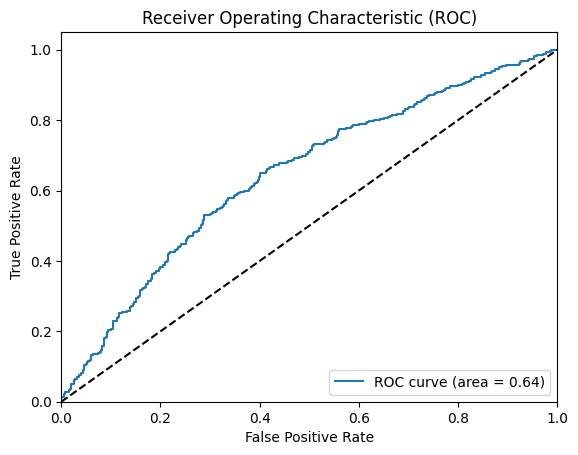

Accuracy score: 0.623
[[280 199]
 [178 343]]


In [73]:
test_models(model_std_relu_dropout, x_test, y_test)

In [74]:
### Brier score
from sklearn.metrics import brier_score_loss
brier_score_loss(y_test, model_std_relu_dropout.predict(x_test))

32/32 [==============================] - 0s 2ms/step


0.23480128908134548

32/32 [==============================] - 0s 2ms/step


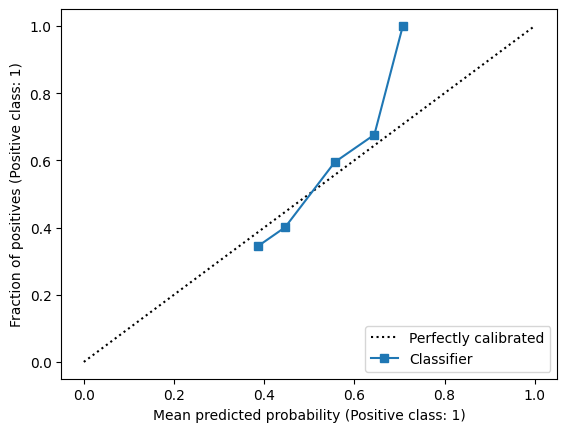

In [75]:
from sklearn.calibration import CalibrationDisplay

display = CalibrationDisplay.from_predictions(y_test, model_std_relu_dropout.predict(x_test), n_bins=10)

### with Brier

In [62]:
def brier_score(y_true, y_pred):
    brier_score = tf.reduce_mean((y_pred - y_true) ** 2, axis=1)
    return brier_score

In [68]:
model_std_relu_dropout = Sequential()
model_std_relu_dropout.add(Dense(512, input_dim=2, activation='relu'))
model_std_relu_dropout.add(Dropout(0.5))
model_std_relu_dropout.add(Dense(1,activation='sigmoid')) # Output
model_std_relu_dropout.compile(loss=brier_score, optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, 
        verbose=1, mode='auto', restore_best_weights=True)

model_std_relu_dropout.fit(x,y,validation_data=(x_val,y_val),
        callbacks=[monitor],epochs=10)


Epoch 1/10
11/94 [==>...........................] - ETA: 0s - loss: 0.2412 

2022-11-28 18:10:05.960434: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


94/94 [==============================] - 1s 6ms/step - loss: 0.2429 - val_loss: 0.2350
Epoch 2/10
 1/94 [..............................] - ETA: 0s - loss: 0.2265

2022-11-28 18:10:06.515581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


94/94 [==============================] - 0s 4ms/step - loss: 0.2403 - val_loss: 0.2359
Epoch 3/10
94/94 [==============================] - 0s 5ms/step - loss: 0.2404 - val_loss: 0.2350
Epoch 4/10
94/94 [==============================] - 0s 5ms/step - loss: 0.2405 - val_loss: 0.2359
Epoch 5/10
94/94 [==============================] - 0s 5ms/step - loss: 0.2400 - val_loss: 0.2370
Epoch 6/10
94/94 [==============================] - 0s 5ms/step - loss: 0.2416 - val_loss: 0.2368
Epoch 6: early stopping


32/32 [==============================] - 0s 2ms/step


2022-11-28 18:10:11.893075: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


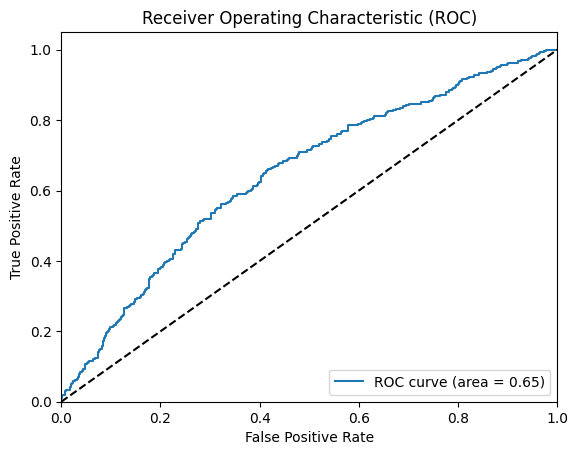

Accuracy score: 0.611
[[290 189]
 [200 321]]


In [69]:
test_models(model_std_relu_dropout, x_test, y_test)

In [70]:
### Brier score
from sklearn.metrics import brier_score_loss
brier_score_loss(y_test, model_std_relu_dropout.predict(x_test))

32/32 [==============================] - 0s 2ms/step


0.23437813386615478

32/32 [==============================] - 0s 2ms/step


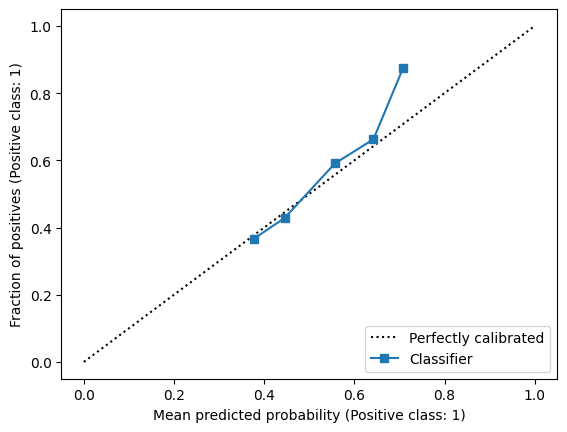

In [71]:
from sklearn.calibration import CalibrationDisplay

display = CalibrationDisplay.from_predictions(y_test, model_std_relu_dropout.predict(x_test), n_bins=10)